In [1]:
import numpy as np
import pandas as pd
import joblib
import warnings
import collections
from itertools import zip_longest

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel

# from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def load_data(data_no=1): 
    data = joblib.load('./train_HA/train_HA_0%d.lz4'%data_no) 
    return data

def moving_average(data, window_size, window_type='rectang'):
    '''
    描述：
        window_type: triang or rectang
    '''
    if window_type == 'triang':
        window = np.linspace(0, 2/(window_size+1), window_size+1)[1:]
    elif window_type == 'rectang':
        window = np.ones(int(window_size))/float(window_size)
    else:
        raise ValueError('window_type error!')
        
    return np.convolve(data, window, 'same')

def df_moving_average(df, window_size, window_type='rectang', columns=None):
    if columns is None:
        columns = ['Current_1', 'Current_2' ,'Current_3']
    
    for col in columns:
        df[col] = moving_average(df[col], window_size, window_type)
    return df

def impute_anomalies_rolling_std(y_old, window_size, sigma=.0, up_thred = 1000, down_thred = 0):
    '''
    描述：
        使用triang窗取均值,检测并使用均值填充异常点
    '''
    y = y_old.copy()
    y[y>20] = 10
    avg = moving_average(y, window_size,window_type= 'triang')
    avg_list = avg.tolist()
    residual = y - moving_average(y, window_size, 'triang')
    # Calculate the variation in the distribution of the residual
    testing_std = pd.Series(residual).rolling(window=window_size, min_periods=1, center=False).std()
    rolling_std = testing_std.replace(np.nan,testing_std.iloc[window_size-1]).values
    
    up_bound = avg + (sigma * rolling_std)
    up_tmp = np.stack([up_bound, np.ones(up_bound.shape[0])*up_thred], axis=0)
    up_bound = np.min(up_tmp, axis=0)
    
    down_bound = avg - (sigma * rolling_std)
    down_tmp = np.stack([down_bound, np.ones(down_bound.shape[0])*down_thred], axis=0)
    down_bound = np.max(down_tmp, axis=0)
    
    f = ((y>up_bound)|(y<down_bound)).values
    y[f] = avg[f]
    
    return y



# def window_fun(x, window_size):
#     '''
#     描述：
#         使用triang窗函数，计算一段序列的最后一个点对应的均值
#     '''
#     window = np.linspace(0, 2/(window_size+1), window_size+1)[1:]
#     delta = len(window) - len(x)
#     if delta>0:
#         tmp = np.array([0]*delta +　list(x))
#         return np.sum(window*tmp)/np.sum(window[delta:])
#     else:
#         tmp = np.array(x[-len(window):])
#         return np.sum(window*tmp)

def predict_trend(x, window_size=8):
    '''
    描述：
        使用二阶插值预测接下来的点
    '''
    ser = pd.Series(x)
    x_train = ser.index[ser != -1].values[-window_size:]
    y_train = ser[ser != -1].values[-window_size:]
    
    # 使用GPR预测趋势
#     kernel = DotProduct() + WhiteKernel() # linear regression 效果类似
#     kernel = RBF()
#     reg = GaussianProcessRegressor(kernel=kernel, 
#                                random_state=0, 
#                                n_restarts_optimizer=3)
    # 使用curve_fit 预测趋势
#     def func(x, a, b):
#         return a*np.exp(b/x)    
    
    if y_train.shape[0] <1:
        return -1
    elif y_train.shape[0] == 1:
        return y_train[0]*1.1
    else: 
       
        # curve_fit 不需要reshape x_train
        # reg.fit(x_train, y_train)
        # reg.predict(np.array(ser.index.max()+1).reshape(-1,1))[0]
#         popt, pcov = curve_fit(func, x_train, y_train)
#         yvals = func(ser.index.max()+1,*popt) #拟合y值
        f1 = np.polyfit(x_train, y_train, 2)
        p1 = np.poly1d(f1)
        yvals = p1(ser.index.max()+1)
        return yvals
    
def CL_mean(df, apply_col, seg_col, up_thred = 30, down_thred= 0, use_pretict=True):
    '''
    描述：
        统计每一段时间的某一列均值，并拟合曲线
    '''
    data = df[apply_col]
    seg_idx = df[seg_col].unique()
    seg_idx.sort()
    
    mean_list = []
    for idx in seg_idx:
        idx_mean = data[df[seg_col] == idx].mean()
        cmp_mean = predict_trend(mean_list)
        if cmp_mean == -1:
            mean_list.append(idx_mean)    
        elif use_pretict and (np.abs(idx_mean - cmp_mean) >= 1.5):
            print(idx, idx_mean ,cmp_mean)
            mean_list.append(cmp_mean)
        else:
            mean_list.append(idx_mean)
         
        # 满足阈值
        if (mean_list[-1]>up_thred) or (mean_list[-1]<down_thred):
            print('ha:',mean_list[-1], idx)
            mean_list[-1] = -1
            
        if len(mean_list) == 1:
            mean_list[0] = 0
            
#     for i in range(len(mean_list)):
#         if i == 0:
#             mean_list[i] = 0
#         elif i == len(mean_list)-1:
#             mean_list[i] = mean_list[i-1]*1.1
#         else:
#             mean_list[i] = (mean_list[i-1] + mean_list[i+1])/2
    return mean_list


def CL_percent_delta(df, apply_col, seg_col, use_predict = True, up=90, down=10, correct_idx=[]):
    '''
    描述：
        统计每一段时间的某一列变化范围，并拟合曲线
        注意：需要手动给出correct_idx
    '''
    data = df[apply_col]
    seg_cl = df[seg_col].unique()
    seg_cl.sort()
    
    delta_list = []
    for cl in seg_cl:
        tmp = data[df[seg_col] == cl]
        up_bound = np.percentile(tmp, up)
        down_bound = np.percentile(tmp, down)
        cl_delta = up_bound - down_bound
        delta_list.append(cl_delta)
    if not use_predict:
        return delta_list
    # 训练gpr模型，预测性地纠正错误的点
    ser = pd.Series(delta_list)
    ser.index = seg_cl
    
    cl = np.array(correct_idx)*5
    x_train = [idx for idx in ser.index if idx not in cl]
    y_train = ser[x_train].values.reshape(-1,1)
    x_train = np.array(x_train).reshape(-1,1)
#     print(x_train, y_train)
    rbf_kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=5.)
    m = GPy.models.GPRegression(x_train, y_train, rbf_kernel)
    m.optimize_restarts(num_restarts=50, verbose=False)

    
    preds = m.predict(np.array([cl]).reshape(-1,1))[0].ravel()
    ser[cl] = preds
    ser[ser<0] = ser[ser>0].min()*0.9
    delta_list = list(ser)
    return delta_list


In [3]:
def CL_mean_auto(df, apply_col, seg_col, up_thred = 30, down_thred= 0, use_pretict=True):
    '''
    描述：
        统计每一段时间的某一列均值，并拟合曲线
    '''
    data = df[apply_col]
    seg_idx = df[seg_col].unique()
    seg_idx.sort()
    
    mean_list = []
    # 标记超出阈值的样本为-1
    for idx in seg_idx:
        idx_mean = data[df[seg_col] == idx].mean()
        mean_list.append(idx_mean)
        if (mean_list[-1]>up_thred) or (mean_list[-1]<down_thred):
            print('标记超出阈值的样本:',mean_list[-1], idx)
            mean_list[-1] = -1
    
    # 拟合粗趋势
    ser = pd.Series(mean_list)
    ser.index = range(ser.shape[0]) #index
    x_train = ser.index[ser != -1].values
    y_train = ser[ser != -1].values
    
    f1 = np.polyfit(x_train, y_train, 2)
    p1 = np.poly1d(f1)
    tmp = p1(ser.index.values)
    mean_list = list(tmp)
    
    # 纠正
    for i,idx in enumerate(seg_idx):
        idx_mean = data[df[seg_col] == idx].mean()
        cmp_mean = mean_list[i]
        if use_pretict and (np.abs(idx_mean - cmp_mean) >= 1.5):
            pass
        else:
            mean_list[i] = idx_mean 
            
    return mean_list

def cl_mean(mean_list, up_thred = 30, down_thred= 0, confidence=0.5):
    mean_list_copy = mean_list
     # 标记超出阈值的样本为-1
    for i in range(len(mean_list)):
        idx_mean = mean_list[i]
        if (idx_mean>up_thred) or (idx_mean<down_thred):
            mean_list[i] = -1
    
    # 拟合粗趋势
    ser = pd.Series(mean_list)
    ser.index = range(ser.shape[0]) #index
    x_train = ser.index[ser != -1].values
    y_train = ser[ser != -1].values
    
    f1 = np.polyfit(x_train, y_train, 2)
    p1 = np.poly1d(f1)
    tmp = p1(ser.index.values)
    mean_list = list(tmp)
    
    # 纠正
    for i in ser.index:
        idx_mean = mean_list_copy[i]
        cmp_mean = mean_list[i]
        if np.abs(idx_mean - cmp_mean) >= confidence:
            pass
        else:
            mean_list[i] = idx_mean 
            
    return mean_list

In [4]:
train_01 = load_data(1)
train_02 = load_data(2)
train_03 = load_data(3)

标记超出阈值的样本: 98.04703808479266 70
标记超出阈值的样本: 34.95250718521592 210


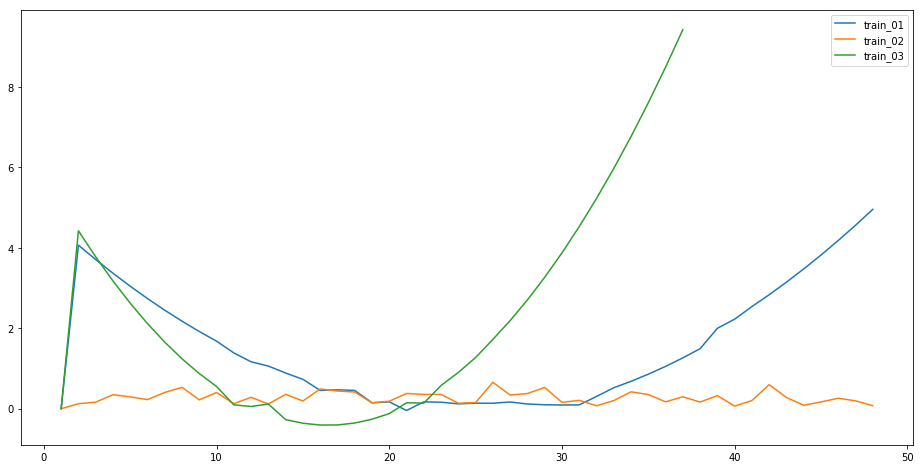

In [5]:
plt.figure(figsize=(16,8))
mean_list = CL_mean_auto(train_01, 'PCA_T2', 'CLI', 30, 0, use_pretict=True)
mean_list = cl_mean(mean_list, confidence=0.3)
mean_list[0] = 0
plt.plot(range(1,49), mean_list, label='train_01')

mean_list = CL_mean_auto(train_02, 'PCA_T2', 'CLI', 30, 0, use_pretict=True)
mean_list = cl_mean(mean_list, confidence=0.3)
mean_list[0] = 0
plt.plot(range(1,49), mean_list, label='train_02')

mean_list = CL_mean_auto(train_03, 'PCA_T2', 'CLI', 30, 0, use_pretict=True)
mean_list = cl_mean(mean_list, confidence=0.3)
mean_list[0] = 0
plt.plot(np.array(range(1,38)), np.array(mean_list), label='train_03')
# plt.plot(np.array(range(1,38)) * 48/37, np.array(mean_list) * 48/37, label='train_03')
plt.legend()

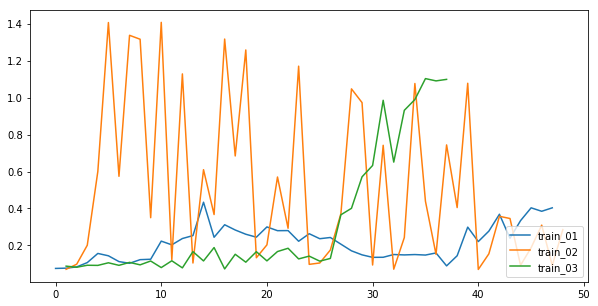

In [6]:
# 手动
plt.figure(figsize=(10,5))
delta_list = CL_percent_delta(df=train_01, apply_col='PCA_T2', seg_col='CLI', use_predict = True, up=90, down=10, correct_idx=[1, 13, 14, 36, 37, 48])
ser = pd.Series(delta_list)
ser.index = range(1,49)
plt.plot(delta_list, label='train_01')

# plt.figure(figsize=(10,5))
delta_list = CL_percent_delta(df=train_02, apply_col='PCA_T2', seg_col='CLI', use_predict = True, up=90, down=10, correct_idx=[14, 21, 35, 38, 42, 43, 46, 48])
ser = pd.Series(delta_list)
ser.index = range(1,49)
plt.plot(ser, label='train_02')


# plt.figure(figsize=(10,5))
delta_list = CL_percent_delta(df=train_03, apply_col='PCA_T2', seg_col='CLI', use_predict = True, up=90, down=10, correct_idx=[1, 8, 20, 30 , 33, 36, 37])
ser = pd.Series(delta_list)
ser.index = range(1,38)
plt.plot(ser, label='train_03')

plt.legend(loc=4)